# Combined Local Neighbors and Clustering-wise weights for KNNimpute
### (Simplified Version)


###### This script is a simplied version of the original notebook ECKNNimpute_das108_workbook which performs K-means clustering on a dataset, calculates pairwise similarity matrices, and generates a combined weight matrix for KNN imputation.

All developed experimental imputation functions from the original notebook have been packaged into a module named imputation_utils.py

**The steps included in this notebook are:**
1. Experimental Design
    <br>1.1 Experimental datasets
    <br>1.2 Experimental run
    <br>1.3 Visualisation (bar charts + line charts)

**Benchmark datasets:**
1. iris.data (Iris)
2. Toxicity-13F.csv (Toxicity)
3. machine.data (Computer hardware)
4. data.csv (2D elastodynamic metamaterials)
5. wholesale_customer_data.csv (Whole customer)

### 1. Experimental Design

#### 1.1 Experimental Datasets 

In [1]:
import pandas as pd

In [2]:
# Life Sciences Datasets
# 1. iris dataset (iris.data) and wisconsine breast cancer wdbc.data
# Toxicity dataset
data = pd.read_csv('iris.data')
data

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
processed_dataset = data.drop(["class"], axis = 1)
processed_dataset

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [4]:
# Rescaling features into a range of [0, 1] using MinMax Scaler
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
scaled_features = minmax_scaler.fit_transform(processed_dataset)
scaled_features_df = pd.DataFrame(scaled_features, columns=processed_dataset.columns)

#### 9.2 Experimental Run

The below implemented code for the experimental analysis compares 3 different imputation methods - ECKNN, feature average (mean imputation), and KNN imputation. It is testing their performance across different missing data rates.

The key steps are:

1. Define parameters like number of trials, iterations, k-neighbors value.

2. Initialize arrays to store the average NRMSE and standard deviation for each method and missing rate. 

3. Loop through each missing rate to test:
   - Generate missing data
   - Impute using each method 
   - Calculate NRMSE

4. For each missing rate loop:
   - Do multiple trials
   - In each trial, calculate NRMSE for each method
   - Store NRMSE in array
   - Calculate average and stddev NRMSE across trials

5. Append the average and stddev NRMSE to the result arrays

6. Print out a summary table showing for each missing rate:
   - The average NRMSE for each method
   - The stddev NRMSE for each method

This allows comparing the performance of the 3 imputation methods across different levels of missing data. The multiple trials account for randomness in missing data generation. 

Key functions it is calling from imputation_utils:
- calculate_avg_similarity_matrix: creates similarity matrix
- artificial_missingness: generates missing data
- feature_average_imputation: imputes by column averages
- ecknn_imputation: does ECKNN imputation (The proposed approach)
- calculate_nrmse: measures error vs original data


In [5]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
import numpy as np
from sklearn.impute import KNNImputer
from imputation_utils import calculate_avg_similarity_matrix, artificial_missingness, feature_average_imputation, ecknn_imputation, calculate_nrmse


# Define the parameters 

# number of trials
num_trials = 10  # You can adjust this number as needed

# number of iterations
num_iters = 10

# k-neighbors value
k = 3

# Define the range of missing rate values to test
missing_rate_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2]  # Adjust as needed

# Initialize arrays to store average NRMSE and standard deviation results for each missing rate
# ecknn imputation
average_ecknn_nrmse_results = []
stddev_ecknn_nrmse_results = []

# Average feature imputation
average_feat_impute_nrmse_results = [] 
stddev_feat_impute_nrmse_results = []

# KNN imputation
average_knn_nrmse_results = []
stddev_knn_nrmse_results = []


# Perform the sequence of functions for each missing rate
for missing_rate in missing_rate_values:
    ecknn_nrmse_results = []
    feat_impute_nrmse_results = []
    knn_nrmse_results = []
    
    for trial in range(num_trials):
        avg_similarity_matrix = calculate_avg_similarity_matrix(scaled_features_df, num_iterations=num_iters)
        missing_dataset = artificial_missingness(processed_dataset, missing_rate=missing_rate)
        avg_imputed_dataset = feature_average_imputation(missing_dataset)
        ecknn_imputed_dataset = ecknn_imputation(missing_dataset, avg_imputed_dataset, avg_similarity_matrix, k_neighbors=k)
        
        # KNN Imputation
        knn_imputer = KNNImputer(n_neighbors=k)
        knn_imputed_dataset = knn_imputer.fit_transform(missing_dataset)
        
        # nrmse calculation
        ecknn_nrmse = calculate_nrmse(processed_dataset, missing_dataset, ecknn_imputed_dataset)
        feat_impute_nrmse = calculate_nrmse(processed_dataset, missing_dataset, avg_imputed_dataset.to_numpy())
        knn_nrmse = calculate_nrmse(processed_dataset, missing_dataset, knn_imputed_dataset)
        
        
        ecknn_nrmse_results.append(ecknn_nrmse)
        feat_impute_nrmse_results.append(feat_impute_nrmse)
        knn_nrmse_results.append(knn_nrmse)
    
    # Calculate and store the average NRMSE and standard deviation
    # ecknn
    average_ecknn_nrmse = np.mean(ecknn_nrmse_results)
    stddev_ecknn_nrmse = np.std(ecknn_nrmse_results)
    
    # feat average impute
    average_feat_impute_nrmse = np.mean(feat_impute_nrmse_results)
    stddev_feat_impute_nrmse = np.std(feat_impute_nrmse_results)
    
    # KNN impute
    average_knn_nrmse = np.mean(knn_nrmse_results)
    stddev_knn_nrmse = np.std(knn_nrmse_results)
    
    
    # ecknn
    average_ecknn_nrmse_results.append(average_ecknn_nrmse)
    stddev_ecknn_nrmse_results.append(stddev_ecknn_nrmse)
    
    # feat average impute
    average_feat_impute_nrmse_results.append(average_feat_impute_nrmse)
    stddev_feat_impute_nrmse_results.append(stddev_feat_impute_nrmse)
    
    # KNN
    average_knn_nrmse_results.append(average_knn_nrmse)
    stddev_knn_nrmse_results.append(stddev_knn_nrmse)

# Print or analyze the results for each missing rate
print(f"Number of Trials: {num_trials}")
print(f"Number of Iterations: {num_iters}")
print(f"K-neighbors: {k}")
print("-" * 30)
      
for i, missing_rate in enumerate(missing_rate_values):
    print(f"Missing Rate: {missing_rate:.1%}")
    print(f" ECKNN: Average NRMSE: {average_ecknn_nrmse_results[i]}, StdDev NRMSE: {stddev_ecknn_nrmse_results[i]}")
    print(f" Feat AVG: Average NRMSE: {average_feat_impute_nrmse_results[i]}, StdDev NRMSE: {stddev_feat_impute_nrmse_results[i]}")
    print(f" KNN: Average NRMSE: {average_knn_nrmse_results[i]}, StdDev NRMSE: {stddev_knn_nrmse_results[i]}")

Number of Trials: 10
Number of Iterations: 10
K-neighbors: 3
------------------------------
Missing Rate: 1.0%
 ECKNN: Average NRMSE: 0.029683531403766356, StdDev NRMSE: 0.013806121101055054
 Feat AVG: Average NRMSE: 0.18753799377379315, StdDev NRMSE: 0.04581654456568675
 KNN: Average NRMSE: 0.04789970104304989, StdDev NRMSE: 0.01776042022270623
Missing Rate: 2.0%
 ECKNN: Average NRMSE: 0.02932740587161118, StdDev NRMSE: 0.010087705921304412
 Feat AVG: Average NRMSE: 0.159753689854164, StdDev NRMSE: 0.03129819761533813
 KNN: Average NRMSE: 0.04070145514777094, StdDev NRMSE: 0.012722367154951267
Missing Rate: 3.0%
 ECKNN: Average NRMSE: 0.0331755123404085, StdDev NRMSE: 0.011080325278115841
 Feat AVG: Average NRMSE: 0.15095806077587864, StdDev NRMSE: 0.035852214032310425
 KNN: Average NRMSE: 0.0457803598242681, StdDev NRMSE: 0.008815822873078555
Missing Rate: 4.0%
 ECKNN: Average NRMSE: 0.029847473592908413, StdDev NRMSE: 0.006476006692765378
 Feat AVG: Average NRMSE: 0.1513429081098087

#### 9.3 Visualisation

##### Bar Charts

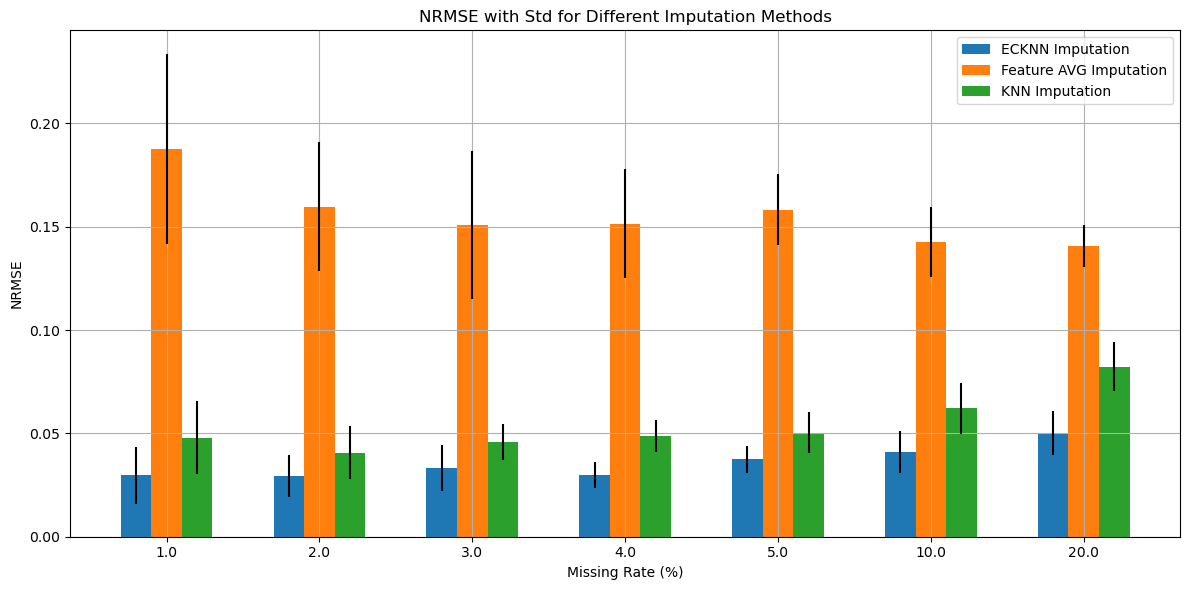

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Convert missing rates to percentages for plotting
missing_rate_percentages = [rate * 100 for rate in missing_rate_values]

# Set the width of the bars
bar_width = 0.2  # Reduce the bar width for spacing

# Calculate the positions for the bars
positions = np.arange(len(missing_rate_values))

# Create a figure and axis for the bar chart
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Create bar chart for average NRMSE with error bars for standard deviation
ax.bar(positions - bar_width, average_ecknn_nrmse_results, bar_width, label='ECKNN Imputation', yerr=stddev_ecknn_nrmse_results)
ax.bar(positions, average_feat_impute_nrmse_results, bar_width, label='Feature AVG Imputation', yerr=stddev_feat_impute_nrmse_results)
ax.bar(positions + bar_width, average_knn_nrmse_results, bar_width, label='KNN Imputation', yerr=stddev_knn_nrmse_results)

# Set x-axis labels and ticks
ax.set_xlabel('Missing Rate (%)')
ax.set_ylabel('NRMSE')
ax.set_title('NRMSE with Std for Different Imputation Methods')
ax.set_xticks(positions)
ax.set_xticklabels(missing_rate_percentages)

# Add legend and grid
ax.legend()
ax.grid(True)

# Show the bar chart
plt.tight_layout()  # Ensures labels are not cut off
plt.show()


##### Line Charts

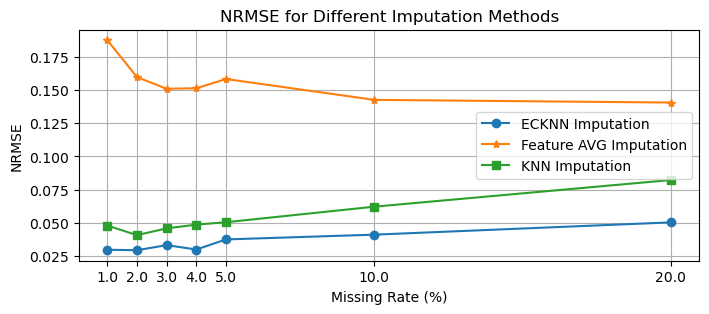

In [8]:
# Line Charts
import numpy as np
import matplotlib.pyplot as plt


# Convert missing rates into percentages for plotting
missing_rate_percentages = [rate * 100 for rate in missing_rate_values]

# Plotting the results
plt.figure(figsize=(8, 3))

# Plot average NRMSE for ecknn imputation
plt.plot(missing_rate_percentages, average_ecknn_nrmse_results, marker='o', label='ECKNN Imputation')

# Plot average NRMSE for feature average imputation
plt.plot(missing_rate_percentages, average_feat_impute_nrmse_results, marker='*', label='Feature AVG Imputation')

# Plot average NRMSE for KNN imputation
plt.plot(missing_rate_percentages, average_knn_nrmse_results, marker='s', label='KNN Imputation')

# Set plot labels and title
plt.xlabel('Missing Rate (%)')
plt.ylabel('NRMSE')
plt.title('NRMSE for Different Imputation Methods')
plt.legend()
plt.grid(True)

# Set exact missing rate percentages as x-axis tick locations and labels
plt.xticks(missing_rate_percentages, missing_rate_percentages)

# Show the plot
plt.show()

#### Plot for ECKNN Model

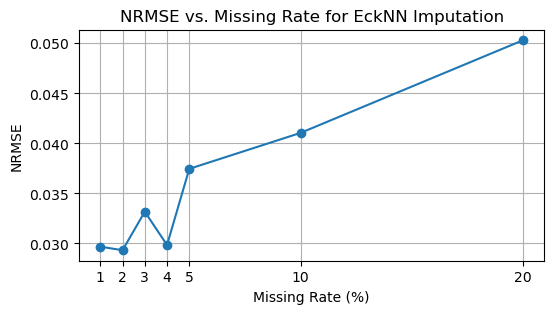

In [9]:
import matplotlib.pyplot as plt
# Plotting 1
plt.figure(figsize=(6, 3))
plt.plot(np.array(missing_rate_values) * 100, average_ecknn_nrmse_results, marker='o')
plt.title("NRMSE vs. Missing Rate for EckNN Imputation")
plt.xlabel("Missing Rate (%)")
plt.ylabel("NRMSE")
plt.grid(True)
plt.xticks(np.array(missing_rate_values) * 100)  # Adjust the x-axis ticks
plt.show()